alt.Chart(...)

alt.Chart(...)

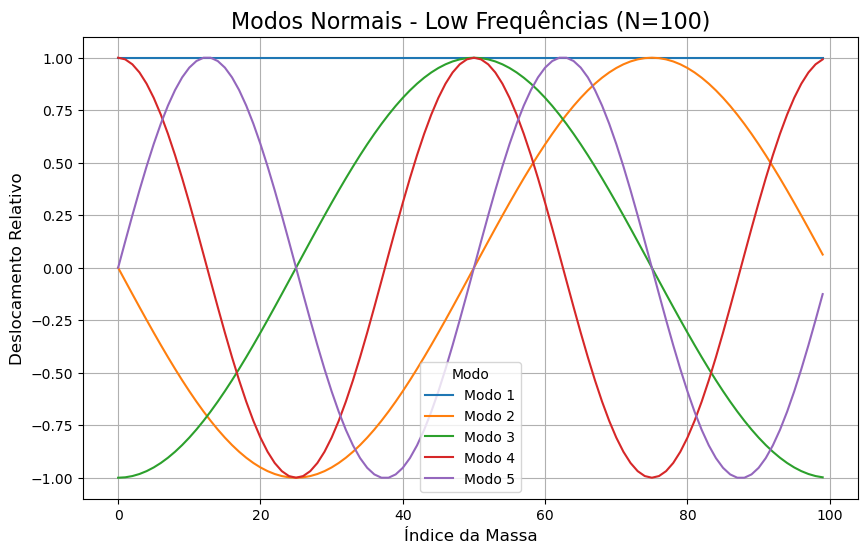

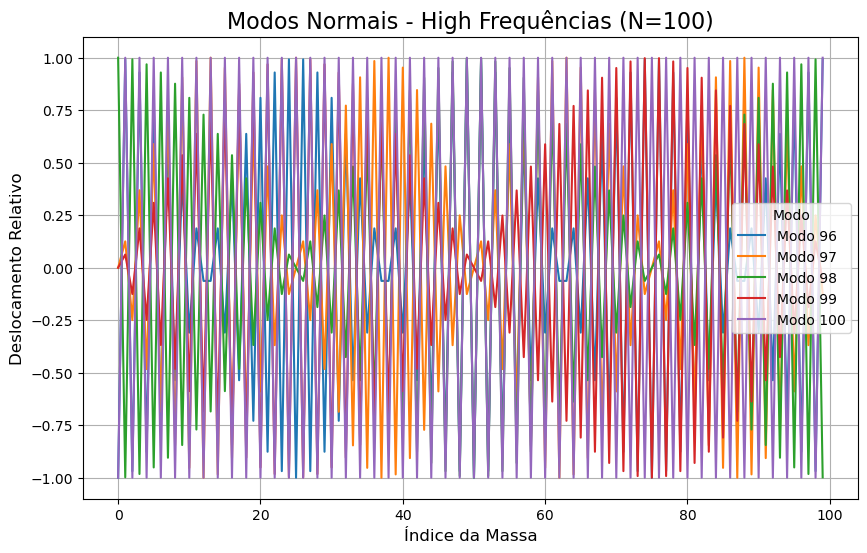

alt.Chart(...)

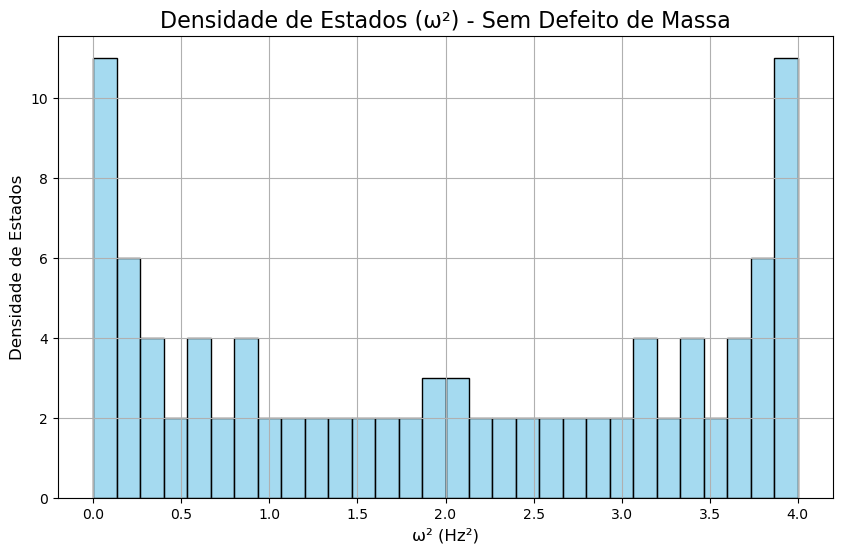

In [1]:
import numpy as np
import os
import altair as alt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Função para criar a pasta de saída
def create_output_directory():
    output_dir = 'figuras'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir

# Função para construir as matrizes de massa e rigidez
def construct_matrices(N, m=1.0, k=1.0, defect=False):
    """
    Constroi as matrizes de massa e rigidez para o sistema de massas e molas.
    Se 'defect' for True, o defeito de massa é introduzido na massa central.
    """
    M = m * np.eye(N)  # Matriz de massa (N x N)
    K = np.zeros((N, N))  # Matriz de rigidez (N x N)
    
    # Definindo a rigidez para as interações entre massas vizinhas
    for i in range(N):
        K[i, i] = 2 * k
        K[i, (i + 1) % N] = -k  # Interação com a próxima massa
        K[i, (i - 1) % N] = -k  # Interação com a massa anterior
    
    if defect:  # Se houver defeito de massa no centro
        m2 = 5 * m
        M[N // 2, N // 2] = m2  # Substitui a massa central pela massa defeituosa
    
    return M, K

# Função para calcular frequências naturais e modos normais
def calculate_frequencies_and_modes(M, K):
    """
    Calcula as frequências naturais e os modos normais do sistema
    através da diagonalização da matriz de rigidez e massa.
    """
    eigenvalues, eigenvectors = np.linalg.eigh(np.linalg.inv(M) @ K)  # Diagonaliza o sistema
    frequencies = np.sqrt(np.abs(eigenvalues))  # Frequências naturais (ω)
    omega_squared = eigenvalues  # ω²
    return frequencies, eigenvectors, omega_squared

# Função para plotar os modos normais de forma interativa usando Altair
def plot_modes_interactive_altair(eigenvectors, frequencies, num_modes=5, mode_type='low', N=100):
    """
    Plota os modos normais do sistema de forma interativa usando Altair.
    """
    if mode_type == 'low':
        modes_to_plot = np.argsort(frequencies)[:num_modes]  # Menores frequências
    else:
        modes_to_plot = np.argsort(frequencies)[-num_modes:]  # Maiores frequências
    
    # Organizando os dados para o Altair
    modes_data = []
    for i, mode_index in enumerate(modes_to_plot):
        displacement = eigenvectors[:, mode_index] / np.max(np.abs(eigenvectors[:, mode_index]))  # Normaliza para o valor máximo
        for idx, disp in enumerate(displacement):
            modes_data.append({
                'Massa': idx,
                'Deslocamento': disp,
                'Modo': f'Modo {mode_index + 1}',
                'Frequência (Hz)': frequencies[mode_index]
            })
    
    df_modes = pd.DataFrame(modes_data)
    
    # Criando o gráfico interativo
    chart = alt.Chart(df_modes).mark_line().encode(
        x='Massa',
        y='Deslocamento',
        color='Modo:N',
        tooltip=['Modo', 'Frequência (Hz)', 'Massa', 'Deslocamento']
    ).properties(
        title=f'Modos Normais - {mode_type.capitalize()} Frequências (N={N})',
        width=600,
        height=400
    ).interactive()
    
    # Exibindo o gráfico
    chart.show()

# Função para plotar o histograma de ω² com Altair
def plot_histogram_interactive_altair(omega_squared, N, defect=False):
    """
    Plota o histograma da densidade de estados para ω² de forma interativa usando Altair.
    """
    # Organizando os dados para o Altair
    df_omega = pd.DataFrame({'omega_squared': omega_squared})
    
    # Criando o gráfico de histograma
    hist_chart = alt.Chart(df_omega).mark_bar().encode(
        x=alt.X('omega_squared', bin=alt.Bin(maxbins=30), title='ω² (Hz²)'),
        y='count():Q',
        tooltip=['omega_squared', 'count():Q']
    ).properties(
        title='Densidade de Estados (ω²)' + (' - Com Defeito de Massa' if defect else ' - Sem Defeito de Massa'),
        width=600,
        height=400
    ).interactive()
    
    # Exibindo o histograma
    hist_chart.show()

# Função para plotar os modos normais de forma estática usando Seaborn
def plot_modes_seaborn(eigenvectors, frequencies, num_modes=5, mode_type='low', N=100):
    """
    Plota os modos normais de forma estática usando Seaborn.
    """
    if mode_type == 'low':
        modes_to_plot = np.argsort(frequencies)[:num_modes]  # Menores frequências
    else:
        modes_to_plot = np.argsort(frequencies)[-num_modes:]  # Maiores frequências
    
    # Organizando os dados para o Seaborn
    modes_data = []
    for i, mode_index in enumerate(modes_to_plot):
        displacement = eigenvectors[:, mode_index] / np.max(np.abs(eigenvectors[:, mode_index]))  # Normaliza para o valor máximo
        for idx, disp in enumerate(displacement):
            modes_data.append({
                'Massa': idx,
                'Deslocamento': disp,
                'Modo': f'Modo {mode_index + 1}',
                'Frequência (Hz)': frequencies[mode_index]
            })
    
    df_modes = pd.DataFrame(modes_data)
    
    # Criando o gráfico estático com Seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Massa', y='Deslocamento', hue='Modo', data=df_modes, palette='tab10')
    plt.title(f'Modos Normais - {mode_type.capitalize()} Frequências (N={N})', fontsize=16)
    plt.xlabel('Índice da Massa', fontsize=12)
    plt.ylabel('Deslocamento Relativo', fontsize=12)
    plt.legend(title='Modo', fontsize=10)
    plt.grid(True)
    
    # Exibindo o gráfico estático
    plt.show()

# Função para plotar o histograma de ω² de forma estática usando Seaborn
def plot_histogram_seaborn(omega_squared, N, defect=False):
    """
    Plota o histograma da densidade de estados para ω² de forma estática usando Seaborn.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(omega_squared, kde=False, bins=30, color='skyblue', edgecolor='black')
    plt.title('Densidade de Estados (ω²)' + (' - Com Defeito de Massa' if defect else ' - Sem Defeito de Massa'), fontsize=16)
    plt.xlabel('ω² (Hz²)', fontsize=12)
    plt.ylabel('Densidade de Estados', fontsize=12)
    plt.grid(True)
    
    # Exibindo o histograma estático
    plt.show()

# Função principal para calcular e plotar os resultados
def analyze_system(N, defect=False):
    """
    Função que calcula as frequências naturais e os modos normais,
    e plota os gráficos interativos e estáticos de ω² e modos normais.
    """
    # Construir as matrizes de massa e rigidez
    m = 1.0
    k = 1.0
    M, K = construct_matrices(N, m, k, defect=defect)
    
    # Calcular as frequências naturais e os modos normais
    frequencies, eigenvectors, omega_squared = calculate_frequencies_and_modes(M, K)
    
    # Plotar os modos normais de forma interativa
    plot_modes_interactive_altair(eigenvectors, frequencies, num_modes=5, mode_type='low', N=N)
    plot_modes_interactive_altair(eigenvectors, frequencies, num_modes=5, mode_type='high', N=N)
    
    # Plotar os modos normais de forma estática
    plot_modes_seaborn(eigenvectors, frequencies, num_modes=5, mode_type='low', N=N)
    plot_modes_seaborn(eigenvectors, frequencies, num_modes=5, mode_type='high', N=N)
    
    # Plotar o histograma de ω² de forma interativa
    plot_histogram_interactive_altair(omega_squared, N, defect)
    
    # Plotar o histograma de ω² de forma estática
    plot_histogram_seaborn(omega_squared, N, defect)

# Exemplo de execução
N = 100
analyze_system(N, defect=False)
